In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from metal.mmtl.cxr.cxr_datasets import CXR8Dataset
from metal.mmtl.cxr.cxr_preprocess import transform_for_dataset

from torchvision import transforms
from PIL.ImageOps import equalize
from metal.mmtl.cxr.torchsample.torchsample.transforms import *

import warnings
warnings.filterwarnings('ignore')

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
os.environ['CXR8IMAGES'] = '/lfs/1/jdunnmon/data/nih/images/images_heq'
path_to_images = os.environ['CXR8IMAGES']
path_to_labels = os.path.join(os.environ['CXRDATA'],'CXR8-ORIG-DRAIN-SLICE-DATA')

In [4]:
#mean = [0.485, 0.456, 0.406]
#std = [0.229, 0.224, 0.225]
res = 1024

    
# define torchvision transforms
data_transforms = transforms.Compose(
        [   
            #transforms.Lambda(lambda x: np.uint8(equalize_adapthist(np.array(x)))),
            #transforms.ToPILImage(),
           # transforms.Lambda(lambda x: equalize(x)),
            transforms.Scale(res),
            transforms.CenterCrop(res),
            transforms.ToTensor(),
            StdNormalize()
           # transforms.Normalize(mean, std),
        ]
)

In [5]:
# Creating datasets and dataloaders
splits = ['train', 'dev', 'test']
dataloaders = {}
for split in splits:
    dataset = CXR8Dataset(
        path_to_images,
        os.path.join(path_to_labels,f"{split}.tsv"),
        split,
        transform= data_transforms,#transform_for_dataset("CXR8",split,{'res':224}),
        subsample=0,
        finding="ALL",
        pooled=False,
        get_uid=False,
        slice_labels="DRAIN",
        single_task="DRAIN",
        return_dict=True
    )
    dataloaders[split] = DataLoader(dataset, **{'num_workers':16, 'batch_size': 16})

In [6]:
Xs = torch.Tensor()
Ys = torch.Tensor()
for ii, batch, in enumerate(dataloaders['train']):
    if ii % 10 == 0:
        print(f"{ii} of {len(dataloaders['train'])} batches complete...")
    x,y = batch
    Xs = torch.cat((Xs,x['data']))
    Ys = torch.cat((Ys,y.float()))

0 of 26 batches complete...
10 of 26 batches complete...
20 of 26 batches complete...


In [7]:
Xs_pos = [x for ii,x in enumerate(Xs) if Ys[ii]==1]
Xs_neg = [x for ii,x in enumerate(Xs) if Ys[ii]==2]

In [19]:
# 4,9 is a good positive, 10 is really obvious -- function dev'd on 4
ex_ind = 9
x_test = Xs_pos[ex_ind][0,:,:]

In [20]:
def get_threshold(x, sigma=0.33):
    x_norm = (x-x.min())/(x.max()-x.min())
    v = x_norm.median()*255 
    lower_thresh = int(max(0, (1.0 - sigma) * v))
    upper_thresh = int(min(255, (1.0 + sigma) * v))
    return x_norm, lower_thresh, upper_thresh

In [23]:
from metal.mmtl.cxr.scripts.slice_modules.canny_seg_slice import get_canny_seg_diff_image
import matplotlib.pyplot as plt

#kernel = np.ones((3,3),np.float32)/9
#x_test_filt = cv2.filter2D(x_test.numpy(),-1, kernel)
sig=0.33
x_test, lower_thresh, upper_thresh = get_threshold(x_test,sig)
# 100 and 150 are good values for lower, upper thresh
kwargs = {'threshold1':lower_thresh, 'threshold2':upper_thresh, 'apertureSize':3, 'L2gradient':True}
diff_img, lungs, edges = get_canny_seg_diff_image(x_test, kwargs=kwargs)

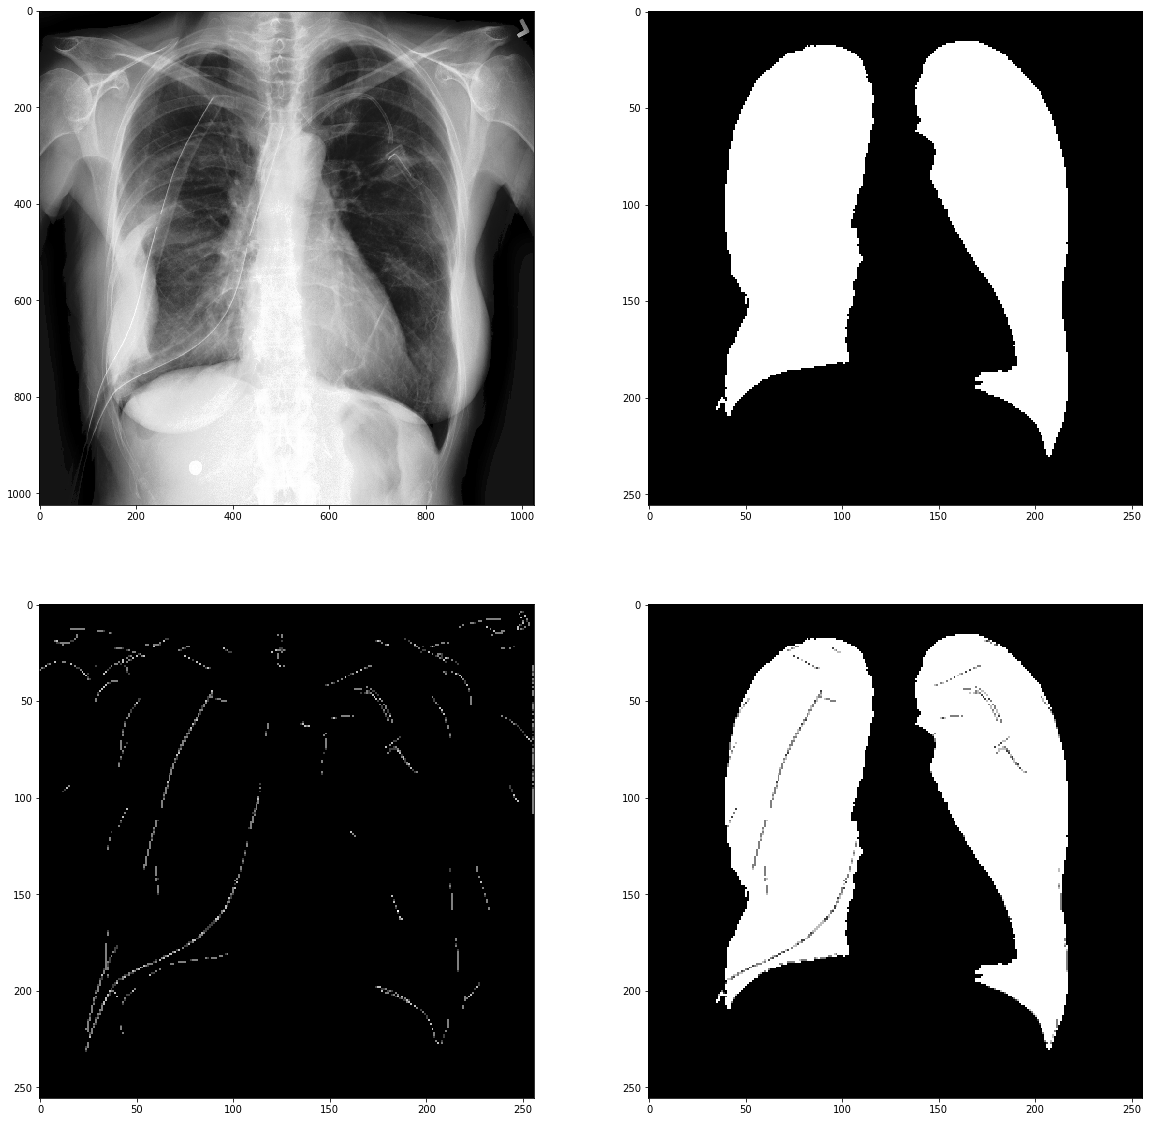

In [24]:
fig, ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].imshow(x_test, cmap='gray');
ax[1,0].imshow(edges, cmap='gray');
ax[0,1].imshow(lungs.squeeze(), cmap='gray');
ax[1,1].imshow(diff_img.squeeze(),cmap='gray')

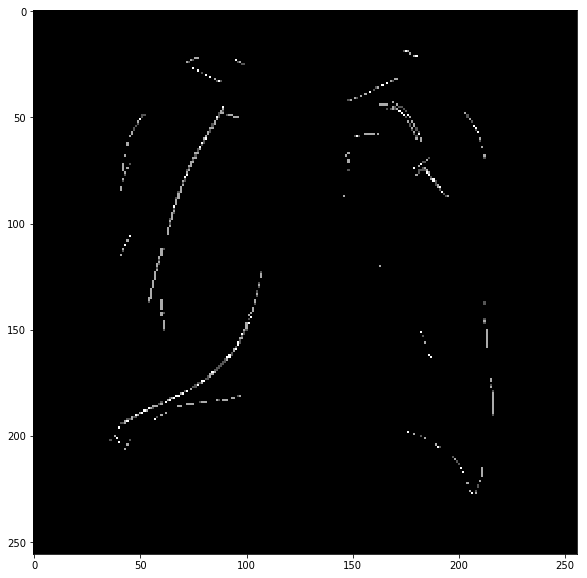

In [25]:
edge_reduced_image = lungs.squeeze()*edges.squeeze()
plt.figure(figsize=(10,10))
plt.imshow(edge_reduced_image, cmap='gray')

In [27]:
# Getting hough lines
import cv2
diff_img_copy = np.uint8(edge_reduced_image.copy()).squeeze()
line_image = np.zeros(diff_img_copy.shape)
minLineLength = 3
maxLineGap=5
lines = cv2.HoughLinesP(diff_img_copy,rho = 1,theta = 1*np.pi/180, threshold=4,minLineLength=minLineLength, maxLineGap=maxLineGap)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image,(x1,y1),(x2,y2),(255,255,255),1)

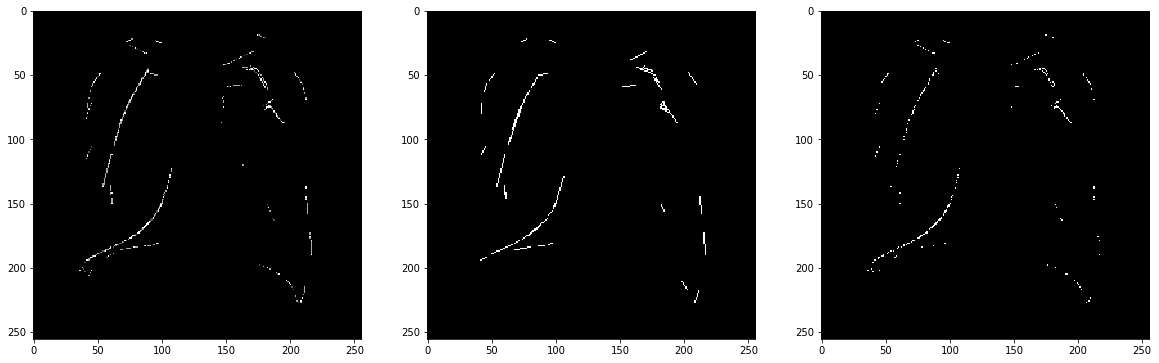

In [28]:
fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(1-edge_reduced_image.squeeze(), cmap='gray');
ax[1].imshow(line_image, cmap='gray');
ax[2].imshow(diff_img_copy-edge_reduced_image*255, cmap='gray');

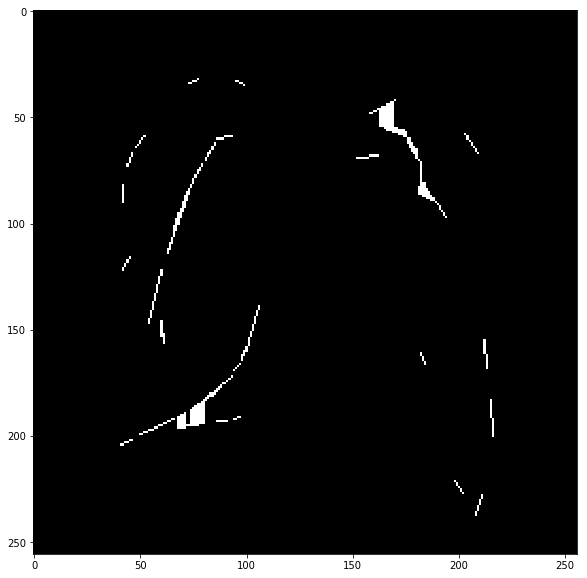

In [30]:
clos = cv2.morphologyEx(line_image, cv2.MORPH_CLOSE, kernel=np.array([2,10]),iterations=10)
plt.figure(figsize=(10,10))
plt.imshow(clos,cmap='gray')

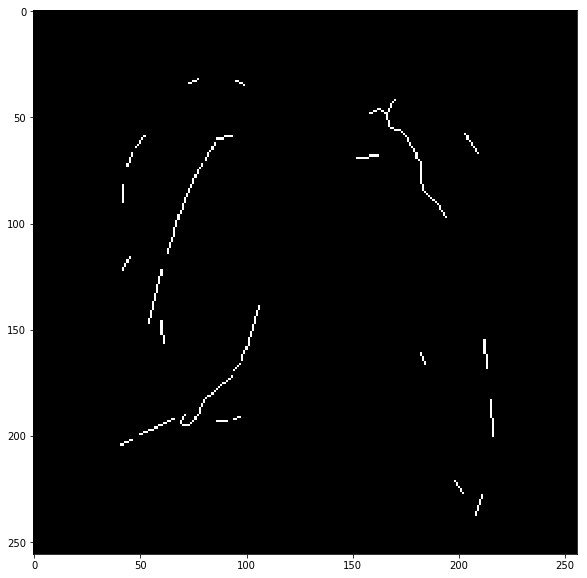

In [34]:
from skimage.morphology import skeletonize
skel = skeletonize(clos/255)
plt.figure(figsize=(10,10))
plt.imshow(skel,cmap='gray')

In [36]:
from skimage import measure
labels = measure.label(skel, neighbors=8, background=0)
from collections import Counter
sorted_components = Counter(labels.flatten()).most_common()[1:] # Ignoring background component

In [37]:
sorted_components

[(3, 67),
 (10, 43),
 (19, 34),
 (13, 26),
 (14, 26),
 (20, 18),
 (22, 17),
 (16, 14),
 (9, 11),
 (15, 11),
 (4, 10),
 (26, 10),
 (7, 9),
 (11, 9),
 (6, 8),
 (8, 7),
 (12, 7),
 (25, 7),
 (5, 6),
 (17, 6),
 (23, 6),
 (24, 6),
 (1, 5),
 (2, 5),
 (18, 4),
 (21, 4)]

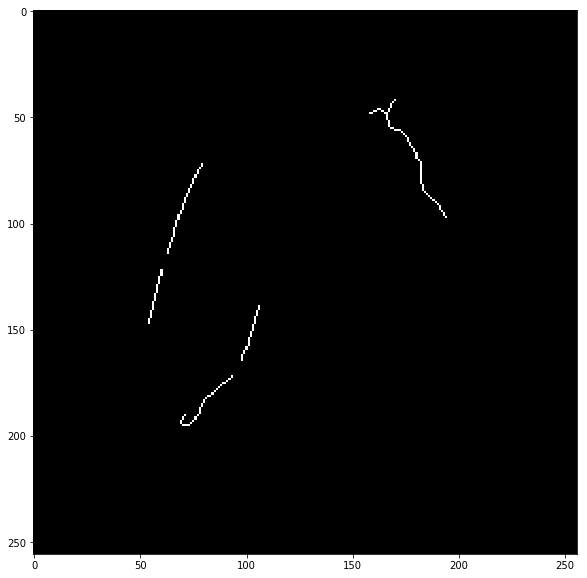

In [48]:
large_comp, length = sorted_components[3]
conn = get_connected_components(skel,length-1)
plt.figure(figsize=(10,10))
plt.imshow(conn,cmap='gray')

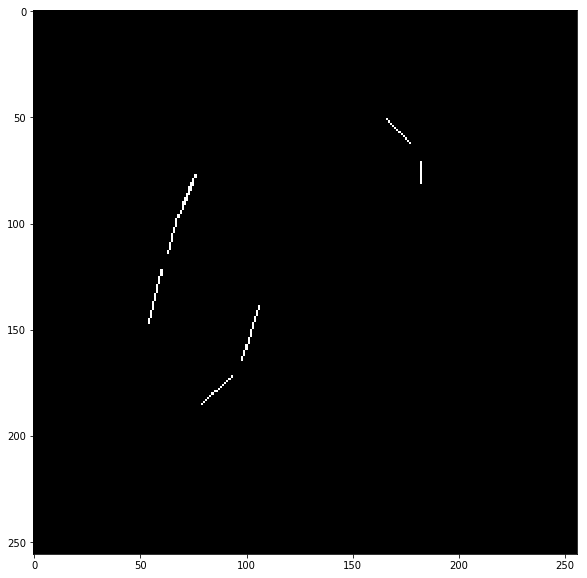

In [49]:
lines_2 = cv2.HoughLinesP(conn,rho = 1,theta = 1*np.pi/180, threshold=4,minLineLength=10, maxLineGap=4)
line_image_2 = np.zeros(line_image.shape)
for line in lines_2:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image_2,(x1,y1),(x2,y2),(255,255,255),1)
plt.figure(figsize=(10,10))
plt.imshow(line_image_2,cmap='gray')

In [50]:
def get_slope(line):
    x1, y1, x2, y2 = line[0]
    slope = (y2-y1)/(x2-x1)
    return slope
#slope_abs = [np.abs(get_slope(line)) for line in lines_2]
#vert = [slope_val>1 for slope_val in slope_abs]

In [51]:
def get_dist(ln):
    x1, y1, x2, y2 = ln
    dist = np.sqrt((x2-x1)**2 + (y1-y2)**2)
    return dist

def slope_percentage(lns):
    if not isinstance(lns, list):
        lns = [lns]
    slope_abs = [np.abs(get_slope(line[0])) for line in lns]
    vert = [slope_val>1 for slope_val in slope_abs]
    return np.sum(vert)/len(vert)

In [55]:
slope_perc = slope_percentage(lines_2)
#dist = get_dist(lines_2[heuristic_line_ind])
print((np.abs(slope_perc)>0.5) and (length>25))


True


In [67]:
from metal.mmtl.cxr.scripts.slice_modules.canny_seg_slice import CannySegSliceModule
modu = CannySegSliceModule()
out, im, lines = modu(x_test[None,None,:,:], return_image=True)

[array([[[183,  83, 193,  95]],
 
        [[162,  46, 170,  56]]], dtype=int32)]

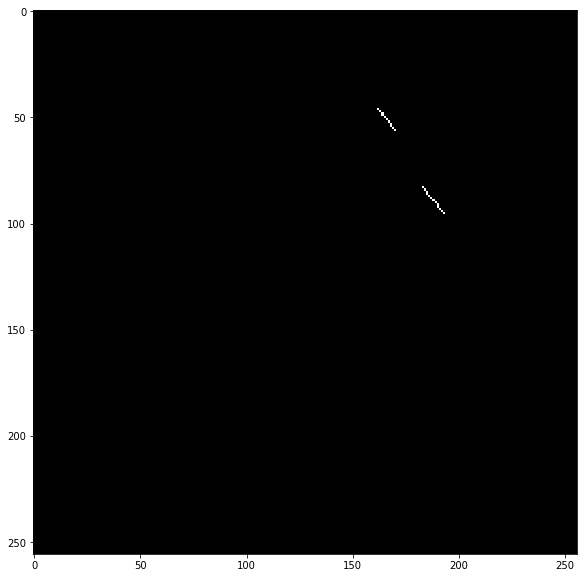

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(im[0], cmap='gray')

In [77]:
x_test.shape

torch.Size([1024, 1024])

## SANDBOX

In [ ]:
import pickle

In [ ]:
from metal.mmtl.cxr.scripts.slice_modules.canny_seg_slice import CannySegSliceModule
import dask
modu = CannySegSliceModule(num_procs=0)
Xs, Ys, Ys_pred = torch.Tensor(), torch.Tensor(), torch.Tensor()
dl = dataloaders['dev']
for ii, batch, in enumerate(dl): 
    if ii % 1 == 0:
        print(f"{ii} of {len(dl)} batches complete...")
    x,y = batch
    y_preds = modu(x)
    Xs = torch.cat((Xs,x))
    Ys = torch.cat((Ys,y.float()))
    Ys_pred = torch.cat((Ys_pred,y_preds.float())) 

In [171]:
from metal.mmtl.cxr.scripts.slice_modules.canny_seg_slice import CannySegSliceModule
import dask

modu = CannySegSliceModule(num_procs=0, lng_cutoff=35, slope_cutoff=0.5)
Xs, Ys, Ys_pred = torch.Tensor(), torch.Tensor(), torch.Tensor()
Y_ims, Y_lines = [],[]
dl = dataloaders['train']
return_image = False

In [ ]:
for ii, batch, in enumerate(dl): 
  #  delayed_results = []
    if ii % 10 == 0:
        print(f"{ii} of {len(dl)} batches complete...")
    x,y = batch
    if not return_image:
        y_preds = modu(x, return_image=False)   
    else:
        y_preds, y_ims, y_lines = modu(x, return_image=return_image)
    Xs = torch.cat((Xs,x))
    Ys = torch.cat((Ys,y.float()))
    Ys_pred = torch.cat((Ys_pred,y_preds.float())) 
    if return_image:
        Y_ims = Y_ims + y_ims
        Y_lines = Y_lines+y_lines

In [158]:
import sklearn.metrics as skm
Ys_eval = np.array(Ys).copy()
Ys_pred_eval = np.array(Ys_pred).copy()
inds = [int(a) != 0 for a in Ys_pred_eval]
Ys_eval = Ys_eval[inds]
Ys_pred_eval = Ys_pred_eval[inds]
# 1: yes drain, 2: no drain

print(skm.classification_report(Ys_eval, np.array(Ys_pred_eval)))
print(f"Coverage: {np.round(len(Ys_eval)/len(Ys),2)}")
print(f"Accuracy: {skm.accuracy_score(Ys_eval, Ys_pred_eval)}")

              precision    recall  f1-score   support

         1.0       0.82      0.75      0.79       280
         2.0       0.62      0.72      0.67       160

   micro avg       0.74      0.74      0.74       440
   macro avg       0.72      0.73      0.73       440
weighted avg       0.75      0.74      0.74       440

Coverage: 1.0
Accuracy: 0.7386363636363636


In [67]:
np.sum(dl.dataset.labels['CXR8_DRAIN']==1)/len(dl.dataset.labels['CXR8_DRAIN'])

0.6363636363636364

In [ ]:
python -W ignore launch_cxr.py --tasks CXR8-DRAIN_ALL --batch_size 16 --n_epochs 10 --lr 0.0001 --l2 0.000 --lr_scheduler linear --run_name test_cv_with_neg_cnn_slice_cv_run_1 --pretrained 1 --drop_rate 0.2 --warmup_steps 0 --warmup_unit epochs --min_lr 1e-6 --res 224 --test_split test --progress_bar 0 --use_slices 1 --seed 1701 --num_workers 8

In [173]:
import pickle
with open('../../scripts/slice_modules/canny_seg_module_35_0p5.pkl','wb') as fl:
    pickle.dump(modu,fl)

In [ ]:
skm.confusion_matrix(Ys_eval,np.array(Ys_pred)) 

In [ ]:
lng_cutoff=40, slope_cutoff=0.5 (dev)

              precision    recall  f1-score   support

         1.0       0.80      0.71      0.75        28
         2.0       0.67      0.76      0.71        21

   micro avg       0.73      0.73      0.73        49
   macro avg       0.73      0.74      0.73        49
weighted avg       0.74      0.73      0.74        49

Coverage: 1.0
Accuracy: 0.7346938775510204
    
lng_cutoff=45, slope_cutoff=0.5 (dev)

              precision    recall  f1-score   support

         1.0       0.86      0.68      0.76        28
         2.0       0.67      0.86      0.75        21

   micro avg       0.76      0.76      0.76        49
   macro avg       0.77      0.77      0.76        49
weighted avg       0.78      0.76      0.76        49

Coverage: 1.0
Accuracy: 0.7551020408163265
    

    lng_cutoff=50, slope_cutoff=0.5 (dev)
    
                  precision    recall  f1-score   support

         1.0       0.90      0.64      0.75        28
         2.0       0.66      0.90      0.76        21

   micro avg       0.76      0.76      0.76        49
   macro avg       0.78      0.77      0.75        49
weighted avg       0.80      0.76      0.75        49

Coverage: 1.0
Accuracy: 0.7551020408163265

        lng_cutoff=35, slope_cutoff=0.5 (dev)

                  precision    recall  f1-score   support

         1.0       0.81      0.75      0.78        28
         2.0       0.70      0.76      0.73        21

   micro avg       0.76      0.76      0.76        49
   macro avg       0.75      0.76      0.75        49
weighted avg       0.76      0.76      0.76        49

Coverage: 1.0
Accuracy: 0.7551020408163265
    
    Precision down at cutoff=30
    
    
FIXED
lng_cutoff=35, slope_cutoff=0.5 (dev)

             precision    recall  f1-score   support

         1.0       0.82      0.82      0.82        28
         2.0       0.76      0.76      0.76        21

   micro avg       0.80      0.80      0.80        49
   macro avg       0.79      0.79      0.79        49
weighted avg       0.80      0.80      0.80        49

Coverage: 1.0
Accuracy: 0.7959183673469388
    
    35, 0.25
                precision    recall  f1-score   support

         1.0       0.81      0.89      0.85        28
         2.0       0.83      0.71      0.77        21

   micro avg       0.82      0.82      0.82        49
   macro avg       0.82      0.80      0.81        49
weighted avg       0.82      0.82      0.81        49
    Coverage: 1.0
Accuracy: 0.8163265306122449

In [ ]:
import sklearn.metrics as skm
Ys_eval = np.array(Ys).copy()
Ys_eval[Ys_eval==2] = 0
print(skm.classification_report(Ys_eval, np.array(Ys_pred)))

array([[16,  5],
       [ 8, 20]])

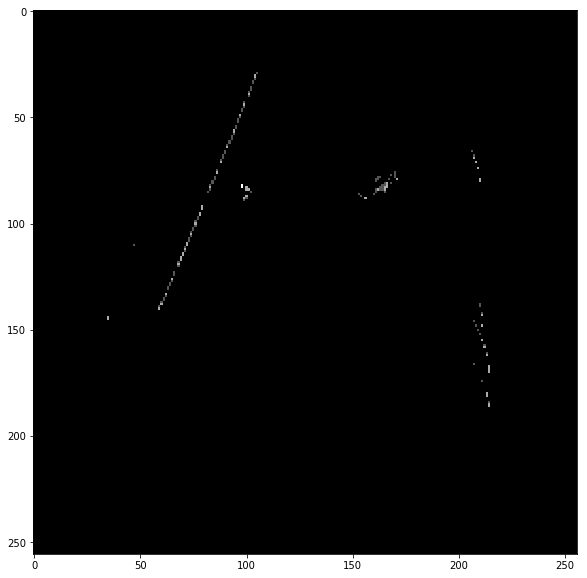

In [552]:
erode1 = cv2.erode(edge_reduced_image, np.array([10,10]), iterations=1)
plt.figure(figsize=(10,10))
plt.imshow(erode1,cmap='gray')
erode1[erode1 != 0] = 255

In [39]:
from skimage import measure
def get_connected_components(im,sz=10):
    # 5. perform a connected component analysis on the thresholded image, then store only the "large" blobs into mask
    labels = measure.label(im, neighbors=8, background=0)
    # mask is initially all black
    mask = np.zeros(im.shape, dtype="uint8")
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue

        # otherwise, construct the mask for this label and count the
        # number of pixels
        labelMask = np.zeros(im.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > sz:
            # add the blob into mask
            mask = cv2.add(mask, labelMask)
    return mask
#plt.imshow(mask, cmap='gray')

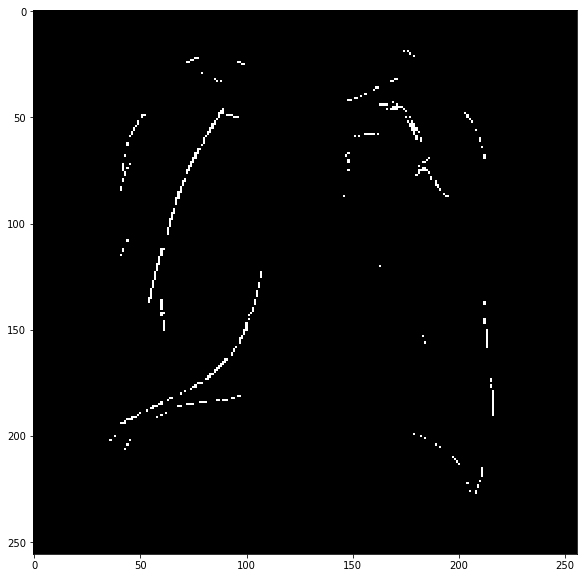

In [40]:
from canny_seg_slice import remove_small_regions
kernel1 = np.ones((20,2),np.uint8)
kernel2 = np.ones((2,1),np.uint8)
kernel3 = np.ones((1,1),np.uint8)
its = 1
out = edge_reduced_image.copy()
#out = cv2.morphologyEx(out, cv2.MORPH_ERODE, kernel2, iterations=1)
out = remove_small_regions(out,100)
#out = cv2.morphologyEx(out, cv2.MORPH_ERODE, kernel3, iterations=1)
#for it in range(its):
#    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, kernel, iterations=1)
#    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, kernel2, iterations=1)
     #out = cv2.morphologyEx(out, cv2.MORPH_CLOSE, kernel1, iterations=1)
plt.figure(figsize=(10,10))
plt.imshow(out ,cmap='gray')

In [459]:
0.001 * np.prod(out.shape)

65.536

In [941]:
diff_img_copy = np.uint8(edge_reduced_image.copy()).squeeze()
line_image = np.zeros(diff_img_copy.shape)
minLineLength = 3
maxLineGap=5
lines = cv2.HoughLinesP(diff_img_copy,rho = 1,theta = 1*np.pi/180, threshold=4,minLineLength=minLineLength, maxLineGap=maxLineGap)

In [942]:
len(lines)

33

In [943]:
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(line_image,(x1,y1),(x2,y2),(255,255,255),2)

ValueError: too many values to unpack (expected 2)

In [944]:
len(lines)
# https://stackoverflow.com/questions/45531074/how-to-merge-lines-after-houghlinesp
# https://stackoverflow.com/questions/53921061/opencv-python-join-line-segments-from-line-segment-detector-lsd-to-form-on
#https://stackoverflow.com/questions/45192280/using-houghlines-on-a-binary-image-to-identify-the-horizontal-and-vertical-comp

33

In [952]:
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image,(x1,y1),(x2,y2),(255,255,255),1)

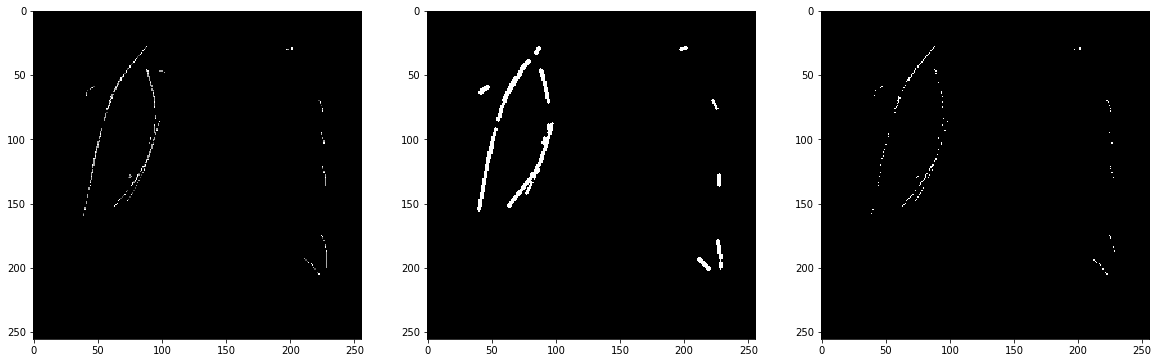

In [953]:
fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(1-edge_reduced_image.squeeze(), cmap='gray');
ax[1].imshow(line_image, cmap='gray');
ax[2].imshow(diff_img_copy-edge_reduced_image*255, cmap='gray');

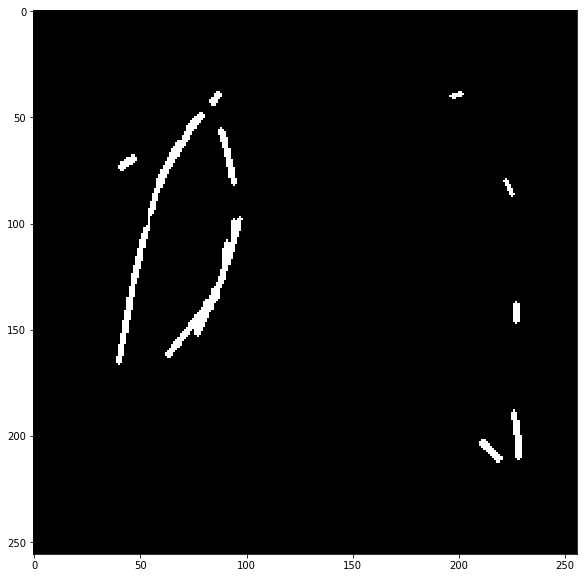

In [999]:
#comp = get_connected_components(line_image,sz=10)
#comp = cv2.erode(comp, None, iterations=1)
comp = cv2.morphologyEx(line_image, cv2.MORPH_CLOSE, kernel=np.array([2,10]),iterations=10)
plt.figure(figsize=(10,10))
plt.imshow(comp,cmap='gray')

In [997]:
from skimage.morphology import skeletonize
skel = skeletonize(comp/255)
plt.figure(figsize=(10,10))
plt.imshow(skel,cmap='gray')

In [1006]:
labels = measure.label(skel, neighbors=8, background=0)

In [1009]:
from collections import Counter
sorted_components = Counter(labels.flatten()).most_common()[1:] # Ignoring background component

In [1013]:
sorted_components

[(3, 116),
 (7, 70),
 (4, 25),
 (9, 21),
 (8, 8),
 (10, 8),
 (6, 7),
 (5, 6),
 (1, 5),
 (2, 3)]

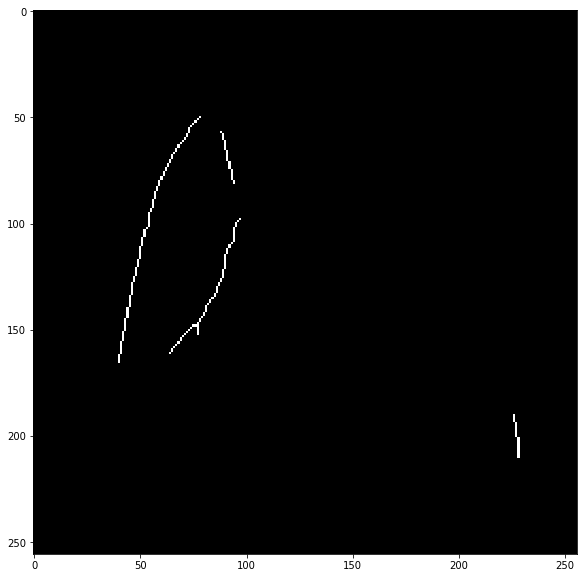

In [1055]:
conn = get_connected_components(skel,20)
plt.figure(figsize=(10,10))
plt.imshow(conn,cmap='gray')

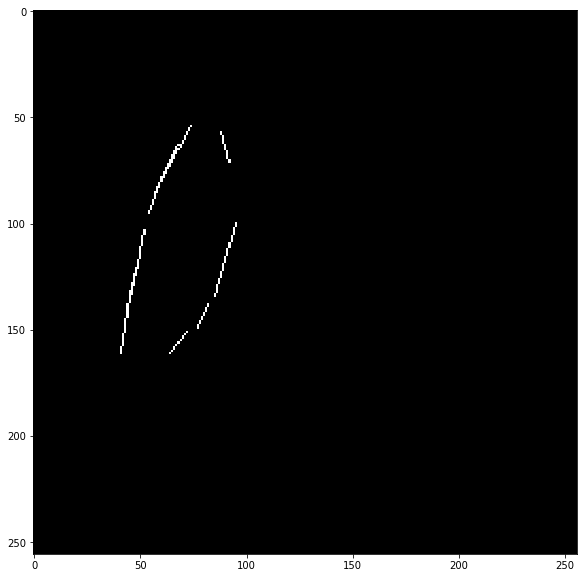

In [1039]:
lines_2 = cv2.HoughLinesP(conn,rho = 1,theta = 1*np.pi/180, threshold=4,minLineLength=10, maxLineGap=4)
line_image_2 = np.zeros(line_image.shape)
for line in lines_2:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image_2,(x1,y1),(x2,y2),(255,255,255),1)
plt.figure(figsize=(10,10))
plt.imshow(line_image_2,cmap='gray')

In [1046]:
def get_slope(line):
    x1, y1, x2, y2 = line[0]
    slope = (y2-y1)/(x2-x1)
    return slope
slope_abs = [np.abs(get_slope(line)) for line in lines_2]
vert = [slope_val>1 for slope_val in slope_abs]

In [1052]:
def slope_heur(lns):
    if np.sum(vert)/len(vert) >0.5:
        return 1
    else:
        return 0

In [992]:
def get_dist(ln):
    x1, y1, x2, y2 = ln
    dist = np.sqrt((x2-x1)**2 + (y1-y2)**2)
    return dist

lines_2 = cv2.HoughLinesP(comp, rho = 1,theta = 1*np.pi/180, threshold=4,minLineLength=minLineLength, maxLineGap=maxLineGap)

In [993]:
len(lines_2)

76

In [994]:
cv2.HoughLinesP?

Docstring:
HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]]) -> lines
.   @brief Finds line segments in a binary image using the probabilistic Hough transform.
.   
.   The function implements the probabilistic Hough transform algorithm for line detection, described
.   in @cite Matas00
.   
.   See the line detection example below:
.   @include snippets/imgproc_HoughLinesP.cpp
.   This is a sample picture the function parameters have been tuned for:
.   
.   ![image](pics/building.jpg)
.   
.   And this is the output of the above program in case of the probabilistic Hough transform:
.   
.   ![image](pics/houghp.png)
.   
.   @param image 8-bit, single-channel binary source image. The image may be modified by the function.
.   @param lines Output vector of lines. Each line is represented by a 4-element vector
.   \f$(x_1, y_1, x_2, y_2)\f$ , where \f$(x_1,y_1)\f$ and \f$(x_2, y_2)\f$ are the ending points of each detected
.   line segment.
.   @param rh

In [995]:
ds = dataloaders['train'].dataset

In [75]:
#[Xs, ys] = map(list, zip(*[(x['data'],y) for x,y in ds]))
Xs = torch.Tensor()
Ys = torch.Tensor()
for ii, batch, in enumerate(dataloaders['train']):
    if ii % 1 == 0:
        print(f"{ii} of {len(dataloaders['train'])} batches complete...")
    x,y = batch
    Xs = torch.cat((Xs,x['data']))
    Ys = torch.cat((Ys,y.float()))

0 of 28 batches complete...
1 of 28 batches complete...
2 of 28 batches complete...
3 of 28 batches complete...
4 of 28 batches complete...
5 of 28 batches complete...
6 of 28 batches complete...
7 of 28 batches complete...
8 of 28 batches complete...
9 of 28 batches complete...
10 of 28 batches complete...
11 of 28 batches complete...
12 of 28 batches complete...
13 of 28 batches complete...
14 of 28 batches complete...
15 of 28 batches complete...
16 of 28 batches complete...
17 of 28 batches complete...
18 of 28 batches complete...
19 of 28 batches complete...
20 of 28 batches complete...
21 of 28 batches complete...
22 of 28 batches complete...
23 of 28 batches complete...
24 of 28 batches complete...
25 of 28 batches complete...
26 of 28 batches complete...
27 of 28 batches complete...


In [78]:
import matplotlib.pyplot as plt
def get_histogram(xs, bins='auto'):
    Xs_flat_list = [x.flatten() for x in xs]
    Xs_flat = torch.cat(Xs_flat_list)
    n, bins, patches = plt.hist(x=Xs_flat, bins=bins, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    return Xs_flat, n, bins, patches

In [339]:
X_pos_flat, n_pos, bin_pos, patch_pos = get_histogram(Xs_pos)
X_neg_flat, n_neg, bin_neg, patch_neg  = get_histogram(Xs_neg, bins=bin_pos)

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fd83a673518>>
Traceback (most recent call last):
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


AttributeError: 'str' object has no attribute 'flatten'

In [42]:
print(X_pos_flat.mean(),X_neg_flat.mean()) 

tensor(0.1169) tensor(0.2172)


In [18]:
from skimage.filters import roberts, sobel, scharr, prewitt
import cv2
import math

def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

def canny_edge_detection(x, kwargs):
    x = np.array(x, dtype=np.uint8)
    x = x+np.min(x)
    return cv2.Canny(x, **kwargs)

def get_center_mask(small_size, large_size):
    B = np.zeros((large_size, large_size))
    nb = large_size
    na = small_size
    lower = int((nb) // 2 - (na // 2))
    upper = int((nb // 2) + (na // 2))
    print(lower, upper)
    B[lower:upper, lower:upper] = 1
    return B
    
def edge_detection(x,fn=roberts,mask_frac=0.8,large_size=224):
    mask_size = int(round_up_to_even(mask_frac*large_size))
    return fn(x,mask=get_center_mask(mask_frac, large_size))

def density_max_threshold(x,thresh):
    x = x.numpy()
    x = x-np.min(x)
    return (x>(thresh*np.max(x)))

def density_min_threshold(x,thresh):
    x = x.numpy()
    x = x-np.min(x)
    return (x<(thresh*np.max(x)))

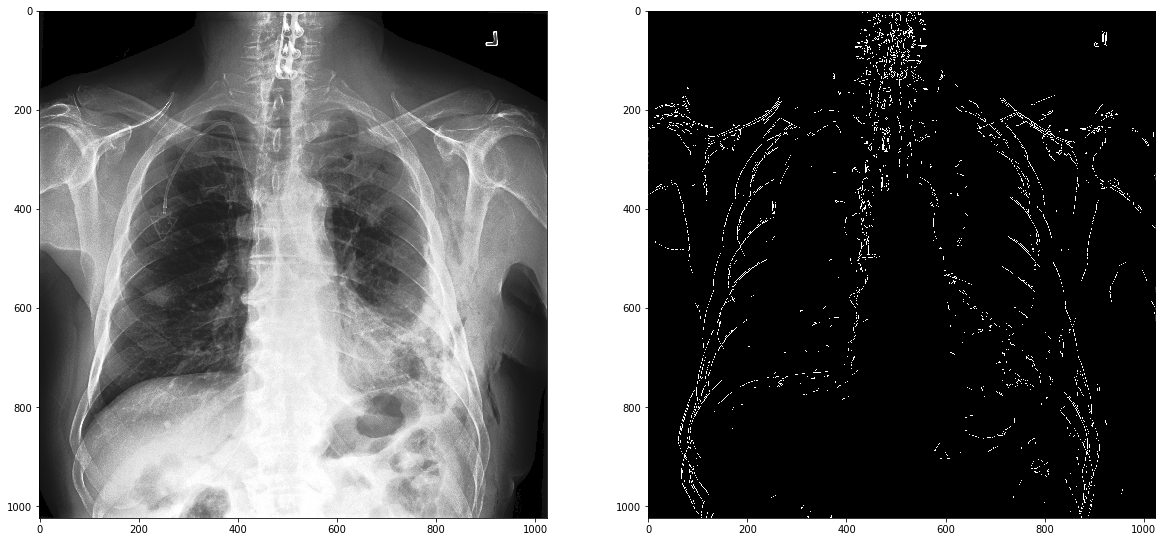

In [19]:
from functools import partial
from skimage.exposure import equalize_adapthist
ex_ind = 29
#proc_fun = partial(density_max_threshold, thresh=0.3)
#proc_fun = partial(edge_detection, large_size=1024, mask_frac=0.8, fn=sobel)
# thresholds 100, 150 work well for non-mean-std data, 1024 res
proc_fun = partial(canny_edge_detection, kwargs={'threshold1':100, 'threshold2':150, 'apertureSize':3, 'L2gradient':True})

x_test = Xs_neg[ex_ind][0,:,:]
#x_test_eq = equalize_adapthist(x_test.numpy())
x_test_proc = proc_fun(x_test*255)

fig, ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(x_test, cmap='gray');
ax[1].imshow(x_test_proc, cmap='gray');

In [193]:
lines = cv2.HoughLines(x_test_proc,1,np.pi/180,100)
x_test_lines = x_test.numpy()
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(x_test_lines,(x1,y1),(x2,y2),(0,0,255),2)

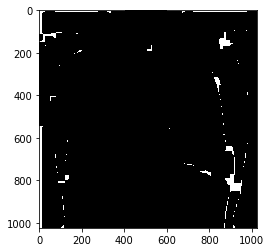

In [194]:
kernel = np.ones((30,30),np.uint8)
closing = cv2.morphologyEx(x_test_proc, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing ,cmap='gray')

In [174]:
img = x_test.numpy()
bw = x_test_proc
contours, heirarchy, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
curves = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
for i in range(len(contours)):
    # for each contour, draw the filled contour
    draw = np.zeros((img.shape[0], img.shape[1]), np.uint8) 
    #cv2.drawContours(draw, contours, i, (255,255,255), -1)
    # for each column, calculate the centroid
    for col in range(draw.shape[1]):
        M = cv2.moments(draw[:, col])
        if M['m00'] != 0:
            x = col
            y = int(M['m01']/M['m00'])
            curves[y, x, :] = (0, 0, 255)

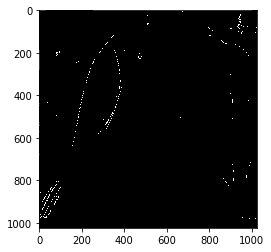

In [176]:
plt.imshow(contours,cmap='gray')

(0.0, 400000)

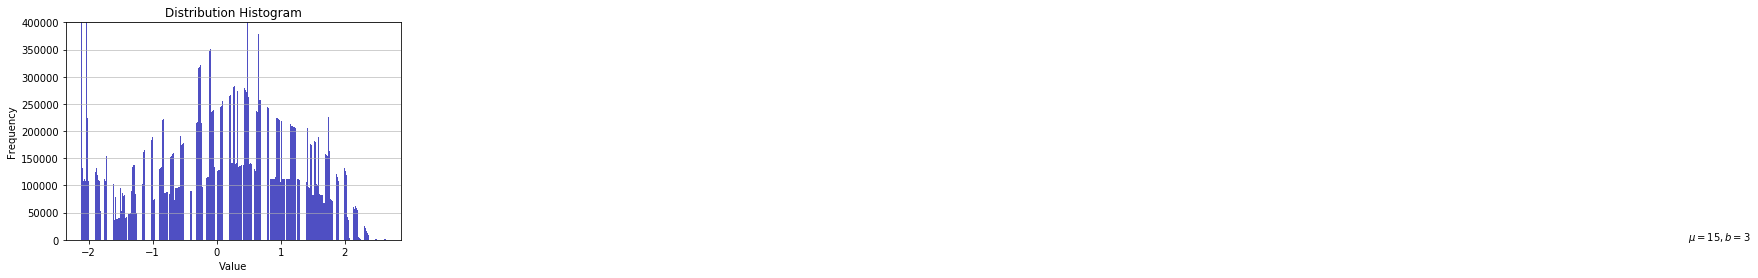

In [191]:
import matplotlib.pyplot as plt
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=Xs_flat, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.ylim(ymax=400000)

In [55]:
cv2.Canny(np.array(x_test, dtype=np.uint8), 100, 200, apertureSize=3, L2gradient=True)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [236]:
# Loading pretrained segnet (from https://github.com/imlab-uiip/lung-segmentation-2d)
from keras.models import load_model
from skimage import exposure, morphology

def get_canny_edges(x):
    proc_fun = partial(canny_edge_detection, kwargs={'threshold1':100, 'threshold2':150, 'apertureSize':3, 'L2gradient':True})

    x_out = proc_fun(x*255)
    return x_out

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

def get_lung_segmentation(x):
    xx = (cv2.resize(x.numpy(), dsize=(256, 256))-mean[0])/std[0]
    im_shape = xx.shape
    xx = xx[None,:,:,None]


    model_name = '../../../../../../lung-segmentation-2d/trained_model.hdf5'
    UNet = load_model(model_name)

    img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1))
    pred = UNet.predict(xx)[..., 0] #.reshape(inp_shape[:2])

    pr = pred > 0.5

    # Remove regions smaller than 2% of the image
    pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))
    return pr, xx

def get_canny_seg_diff_image(x):
    edges = get_canny_edges(x)
    lungs = get_lung_segmentation(x)
    
    # resizing to align with lung segmentation
    edges = cv2.resize(edges, dsize=(256, 256))
    
    # getting difference image
    diff_img = (lungs*255 - x_test_proc_ds)*pr
    
    return diff_img

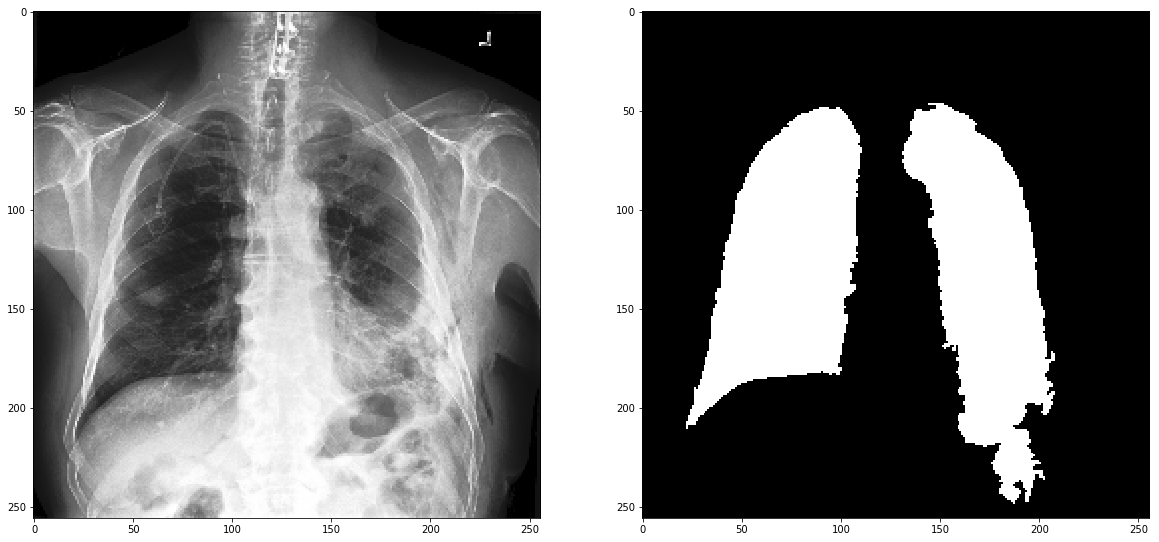

In [234]:
x_test = Xs_neg[ex_ind][0,:,:]
pr, xx = get_lung_segmentation(x_test)
fig, ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(xx[0,:,:,0], cmap='gray');
ax[1].imshow(pr.squeeze(), cmap='gray');

In [237]:
diff_img = get_canny_seg_diff_image(x_test)
plt.imshow(diff_img.squeeze(), cmap='gray')

ValueError: could not broadcast input array from shape (256,256,1) into shape (1,256,256)